# Figure 8.  In- and out-of-vocab performance in n-way

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('..')

In [2]:
neuron_df = pd.read_csv('experiments/trials/results/neuron_classification.csv')
vanilla_df = pd.read_csv('experiments/trials/results/baseline.csv')

### Figure 8 (a)


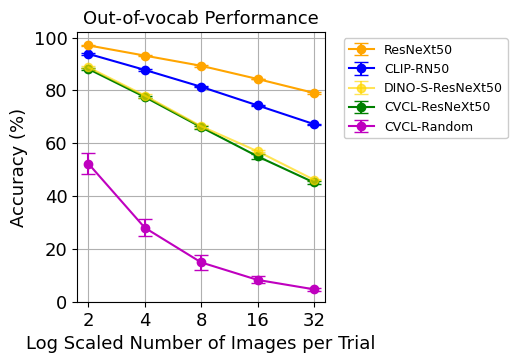

In [6]:
from matplotlib.ticker import MultipleLocator

neuron_df_oov = neuron_df[neuron_df['class_type'] == 'unseen']
neuron_df_oov = neuron_df_oov.sort_values(['num_img_per_trial', 'overall_accuracy'], ascending=[True, False])

grouped = neuron_df_oov.groupby(['model', 'num_img_per_trial']).agg({
    'overall_accuracy': ['mean', 'std', 'count']
}).reset_index() # count is number of exp of each row


fig, ax = plt.subplots(figsize=(3.2, 3.5))


model_names = {
    'resnext': 'ResNeXt50',
    'clip-res': 'CLIP-RN50',
    'dino_s_resnext50': 'DINO-S-ResNeXt50',
    'cvcl-resnext': 'CVCL-ResNeXt50',
    'cvcl-random': 'CVCL-Random'
}

colors = {'cvcl-resnext': 'g', 
          'cvcl-random':'m',
          'resnext':'orange',
          'clip-res':'b',
          'dino_s_resnext50':'#FFD700AA'} 

for model, group in grouped.groupby('model'):
    # Filter data points between 2 and 32
    group = group[(group['num_img_per_trial'] >= 2) & (group['num_img_per_trial'] <= 32)]
    ax.errorbar(group['num_img_per_trial'], group['overall_accuracy']['mean'], yerr=group['overall_accuracy']['std'],
                label=model_names[model], color=colors[model], marker='o', linestyle='-', capsize=5)


num_images = np.array([2, 4, 8, 16, 32])  
baseline = 1 / num_images
# ax.plot(num_images, baseline, label='Random Guess', color='black', linestyle='--', marker='x', markersize=8)


ax.set_xscale('log', base=2)
ax.set_xticks(num_images)
ax.set_xticklabels(num_images)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())


ax.yaxis.set_major_formatter(lambda x, p: f'{int(x*100)}') 
ax.yaxis.set_major_locator(MultipleLocator(0.2))  
ax.set_ylim(0, 1.02)  

ax.tick_params(axis='both', which='major', labelsize=13) 

title_font = 13 
ax.set_xlabel('Log Scaled Number of Images per Trial', fontsize=title_font)
ax.set_ylabel('Accuracy (%)', fontsize=title_font)
ax.set_title('Out-of-vocab Performance', fontsize=title_font)
# Create ordered handles and labels
handles, labels = ax.get_legend_handles_labels()
# Create a mapping of label to handle
label_handle_map = dict(zip(labels, handles))

# Define desired order
desired_order = ['ResNeXt50', 'CLIP-RN50', 'DINO-S-ResNeXt50', 'CVCL-ResNeXt50', 'CVCL-Random']

# Reorder handles based on desired order
ordered_handles = [label_handle_map[label] for label in desired_order]
ordered_labels = desired_order

ax.legend(ordered_handles, ordered_labels, 
        #  title='Model',
         bbox_to_anchor=(1.05, 1), 
         loc='upper left', 
         fontsize=9,
         framealpha=1.0)

plt.grid(True)
# plt.savefig('plots/out-of-vocab_acc.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Figure 8 (b)

In [7]:
def preprosess_df(df):
    models = ['clip-res', 'cvcl-resnext']
    df = df[df['model'].isin(models)]

    # Change & to and for boolean indexing
    df_in_vocab = df[(df['class_type']=='seen')]
    df_in_vocab = df_in_vocab.sort_values(['num_img_per_trial', 'overall_accuracy'], ascending=[True, False])
    
    df_in_vocab = df_in_vocab.groupby(['model', 'num_img_per_trial']).agg({
        'overall_accuracy': ['mean', 'std', 'count']
    }).reset_index()
    return df_in_vocab

In [8]:
vanilla_df_iv = preprosess_df(vanilla_df)
neuron_df_iv = preprosess_df(neuron_df)

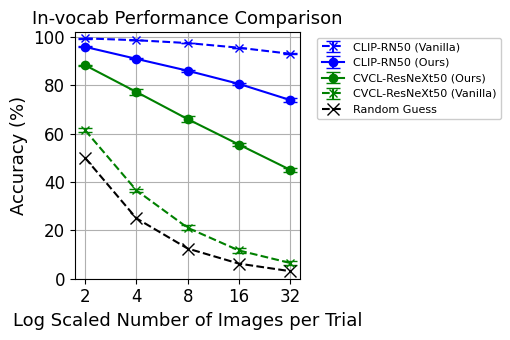

In [9]:
from matplotlib.ticker import MultipleLocator

# Plotting
fig, ax = plt.subplots(figsize=(5.3, 3.5))

# Define model name mappings
model_names = {
    'clip-res': 'CLIP-RN50',
    'cvcl-resnext': 'CVCL-ResNeXt50'
}

# Define colors and styles
colors = {
    'clip-res': 'b',
    'cvcl-resnext': 'g'
}

styles = {
    'baseline': {'linestyle': '--', 'marker': 'x'},
    'neuron': {'linestyle': '-', 'marker': 'o'}
}

# Plot baseline data
for model in ['clip-res', 'cvcl-resnext']:
    model_data = vanilla_df_iv[vanilla_df_iv['model'] == model]
    ax.errorbar(model_data['num_img_per_trial'], 
                model_data['overall_accuracy']['mean'],
                yerr=model_data['overall_accuracy']['std'],
                label=f"{model_names[model]} (Vanilla)",
                color=colors[model],
                **styles['baseline'],
                capsize=5)

# Plot neuron data
for model in ['clip-res', 'cvcl-resnext']:
    model_data = neuron_df_iv[neuron_df_iv['model'] == model]
    ax.errorbar(model_data['num_img_per_trial'], 
                model_data['overall_accuracy']['mean'],
                yerr=model_data['overall_accuracy']['std'],
                label=f"{model_names[model]} (Ours)",
                color=colors[model],
                **styles['neuron'],
                capsize=5)

# Calculate and plot the random baseline
num_images = np.array([2, 4, 8, 16, 32])
baseline = 1 / num_images
ax.plot(num_images, baseline, label='Random Guess', 
        color='black', linestyle='--', marker='x', markersize=8)

# Set x-axis to log scale
ax.set_xscale('log', base=2)
ax.set_xticks(num_images)
ax.set_xticklabels(num_images)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Format y-axis as percentage
ax.yaxis.set_major_formatter(lambda x, p: f'{int(x*100)}')  # Format as 0-100 without % symbol
ax.yaxis.set_major_locator(MultipleLocator(0.2))  # Set major ticks every 0.2 (20 in display)
ax.set_ylim(0, 1.02)  # Keep original 0-1 scale

# Labels and formatting
title_font = 13 
ax.tick_params(axis='both', which='major', labelsize=12)    
ax.set_xlabel('Log Scaled Number of Images per Trial', fontsize=title_font)
ax.set_ylabel('Accuracy (%)', fontsize=title_font)
ax.set_title('In-vocab Performance Comparison', fontsize=title_font)

# Create ordered handles and labels
handles, labels = ax.get_legend_handles_labels()
# Create a mapping of label to handle
label_handle_map = dict(zip(labels, handles))

# Define desired order
desired_order = [
    'CLIP-RN50 (Vanilla)',
    'CLIP-RN50 (Ours)',
    'CVCL-ResNeXt50 (Ours)',
    'CVCL-ResNeXt50 (Vanilla)',
    'Random Guess'
]

# Reorder handles based on desired order
ordered_handles = [label_handle_map[label] for label in desired_order]
ordered_labels = desired_order

ax.legend(ordered_handles, ordered_labels, 
         bbox_to_anchor=(1.05, 1), 
         loc='upper left', 
         fontsize=8,
         framealpha=1.0)


plt.grid(True)
plt.tight_layout()
# plt.savefig('plots/in-vocab_acc.pdf', bbox_inches='tight', dpi=300)
plt.show()